In [ ]:
!pip install torch transformers
!rm -f wassa2023-shared-task.tar.gz
!wget 'https://raw.githubusercontent.com/00ber/ml-projects/main/data/wassa2023-shared-task.tar.gz'
!tar -xf wassa2023-shared-task.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.9 MB/s eta 0:00:00
--2023-05-05 23:10:32--  https://raw.githubusercontent.com/00ber/ml-projects/main/data/wassa2023-shared-task.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4321231 (4.1M) [application/octet-stream]
Saving to: ‘wassa2023-shared-task.tar.gz’

wassa2023-shared-ta 100%[===================>]   4.12M  --.-KB/s    in 0.01s   

2023-05-05 23:10:33 (276 MB/s) - ‘wassa2023-shared-task.tar.gz’ saved [4321231/4321231]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
_df = pd.read_table("/content/WASSA23_conv_level_with_labels_train.tsv")
target_column = "Empathy"
classes = sorted(_df[target_column].unique())
indices = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
vtol = {str(v): indices[i] for i, v in enumerate(classes)}
ltov = {vtol[v]:v for v in vtol}

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset

class ConversationDataset(Dataset):
  def __init__(self, path, tokenizer, label_col, max_token_len=512, sample=2000):
    self.path = path
    self.tokenizer = tokenizer
    self.label_col = label_col
    self.max_token_len = max_token_len
    self.sample = sample 
    self._prepare_data()

  def _prepare_data(self):
    self.df = pd.read_table(self.path["convs"])
    if "conv_labels" in self.path:
      conv_labels_df = pd.read_table(self.path["conv_labels"], names=["EmotionalPolarity", "Emotion", "Empathy"])
      self.df = pd.concat([self.df, conv_labels_df], axis=1)

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    item = self.df.iloc[idx]
    label_value = str(item[self.label_col])
    encoded_label = vtol[label_value]
    text_original = f"[[[[{encoded_label}]]]]" + item.text
    text_masked = "[[[[<mask>]]]]" + item.text

    tokens_original = self.tokenizer.encode_plus(
        text_original,
        add_special_tokens=True,
        return_tensors="pt",
        truncation=True,
        max_length=self.max_token_len,
        padding="max_length",
        return_attention_mask=True
    )
    tokens_masked = self.tokenizer.encode_plus(
        text_masked,
        add_special_tokens=True,
        return_tensors="pt",
        truncation=True,
        max_length=self.max_token_len,
        padding="max_length",
        return_attention_mask=True
    )
    labels = tokens_original.input_ids.detach().clone().flatten()
    input_ids = tokens_masked.input_ids.flatten()
    labels[input_ids != self.tokenizer.mask_token_id] = -100
    return {
        "input_ids": tokens_masked.input_ids.flatten(),
        "attention_mask": tokens_masked.attention_mask.flatten(),
        "labels": labels,
        "original": text_original,
        "masked": text_masked,
        "target_value": label_value,
        "encoded_target_value": encoded_label
    }


In [ ]:
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AdamW, AutoModelForMaskedLM
import torch.nn as nn
import torch.nn.functional as F


train_path = {
    "convs": "/content/WASSA23_conv_level_with_labels_train.tsv",
    "essays": "/content/WASSA23_essay_level_with_labels_train.tsv",
    "articles": "/content/articles_adobe_AMT.csv"
}
val_path = {
    "convs": "/content/WASSA23_conv_level_dev.tsv",
    "conv_labels": "/content/goldstandard_CONV_dev.tsv",
    "essays": "/content/WASSA23_essay_level_dev.tsv",
    "essay_labels": "/content/goldstandard_dev.tsv",
    "articles": "/content/articles_adobe_AMT.csv"
}


batch_size = 64
model_name = "roberta-base"
max_len = 96
label_col = target_column
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

train_ds = ConversationDataset(train_path, tokenizer, label_col, max_len)
val_ds = ConversationDataset(val_path, tokenizer, label_col, max_len)

val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False
)

In [ ]:
from transformers import TrainingArguments
import numpy as np

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/MSML-641-empathy/models/roberta-mlm-empathy/',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    learning_rate=1e-5,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=300,
    logging_steps=300,
    save_strategy="epoch",
    save_total_limit=2,
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
300,3.290600,2.492108
600,2.338900,2.281677
900,2.171400,2.253300
1200,2.131100,2.152721
1500,2.055100,2.171292
1800,2.017100,2.102383
2100,2.010800,2.120810
2400,1.946400,2.153363
2700,1.858900,2.163196
3000,1.914900,2.125228


TrainOutput(global_step=3291, training_loss=2.1497924396673693, metrics={'train_runtime': 952.7582, 'train_samples_per_second': 27.633, 'train_steps_per_second': 3.454, 'total_flos': 1299609959560704.0, 'train_loss': 2.1497924396673693, 'epoch': 3.0})

In [ ]:
from tqdm.auto import tqdm

predictions = []
with torch.no_grad():
  model.eval()
  for i in tqdm(range(len(val_ds))):
    item = val_ds[i]
    input_ids = item["input_ids"].to(device).reshape(1, -1)
    attention_mask = item["attention_mask"].to(device).reshape(1, -1)
    labels = item["labels"].to(device).reshape(1, -1)
    original_text = item["original"]
    masked_text = item["masked"]
    true_value = item["target_value"]

    output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    mask_token_index = (input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
    predicted_token_id = output.logits[0, mask_token_index].argmax(axis=-1)
    predicted_value = tokenizer.decode(predicted_token_id)
    decoded = ltov[predicted_value]
    predictions.append(float(decoded))
  

  0%|          | 0/2400 [00:00<?, ?it/s]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
_df = pd.read_table(train_path["convs"])
ohe.fit(_df[[label_col]])

predictions_ = pd.DataFrame(predictions, columns=[label_col], dtype="float64")

_transformed = ohe.transform(predictions_[[label_col]]).toarray()
_ohe_df = pd.DataFrame(_transformed, columns=ohe.get_feature_names_out())
predictions_tr = pd.concat([predictions_, _ohe_df], axis=1).drop([label_col], axis=1)
final_pr = predictions_tr.to_numpy()

_val_df = pd.read_table('/content/goldstandard_CONV_dev.tsv', names=["EmotionalPolarity", "Emotion", "Empathy"])
transformed = ohe.transform(_val_df[[label_col]]).toarray()
ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names_out())
val_data = pd.concat([_val_df, ohe_df], axis=1).drop(["Empathy", "EmotionalPolarity", "Emotion"], axis=1)
labels = val_data.to_numpy()

final_pr.shape == labels.shape


True

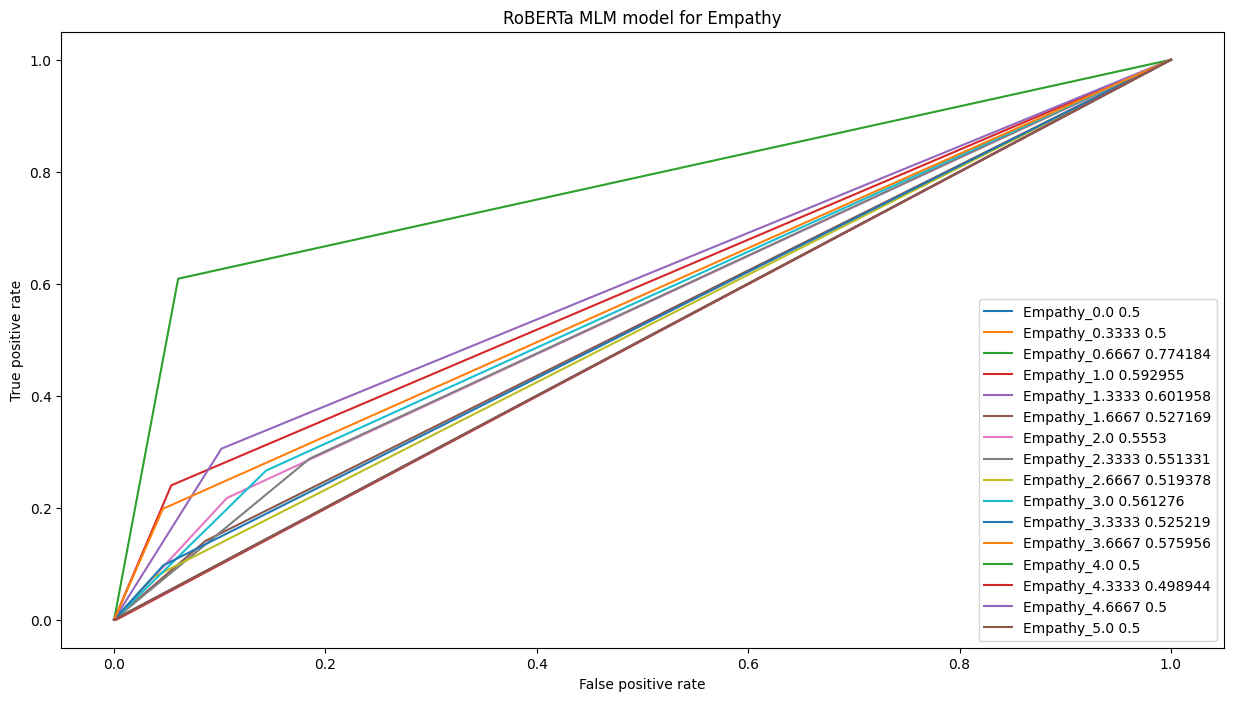

In [ ]:
# Plot
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
for i, label in enumerate(ohe.get_feature_names_out()):
  fpr, tpr, _ = metrics.roc_curve(
      labels[:,i].astype(float), final_pr[:,i]
  )
  auc = metrics.roc_auc_score(
      labels[:,i].astype(float), final_pr[:,i]
  )
  plt.plot(fpr, tpr, label="%s %g" %(label, auc))
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.legend(loc="lower right")
  plt.title("RoBERTa MLM model for Empathy")